# Image classification - Pneumonia

Code for this example comes from [Chapter 1](https://colab.research.google.com/github/fastai/fastbook/blob/master/01_intro.ipynb#scrollTo=51rjRXOLDugq) of
Deep Learning for Coders with fastai & PyTorch by Jeremy Howard and Sylvain Gugger.

## Setup

Load libraries and initial environment variables

In [356]:
import pandas as pd
import os

PROJECT_PATH = '../'


Setting up drive for google colab (skip if running locally)

In [357]:
from google.colab import drive

#Check if drive is already mounted
if not os.path.exists("/content/drive/MyDrive"):
  print("Mounting Google Drive...")
  drive.mount("/content/drive")
  print("✓ Drive mounted successfully!")
else:
  print("✓ Drive already mounted")

PROJECT_PATH = '/content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification'

✓ Drive already mounted


In [358]:

# Set up working directories

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')

print(f'Project path: {PROJECT_PATH}')
print(f'Data will be saved to: {DATA_PATH}')
print(f'Models will be saved to: {MODEL_PATH}')

Project path: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification
Data will be saved to: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data
Models will be saved to: /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/models


### Change the runtime

Change the Runtime to utilize the NVIDIA T4 GPU, if it is not already set to the GPU.

In the menu above click
Runtime $\rightarrow$ Change runtime type and change Hardware accelerator to T4 GPU

### Import the `fastai` library

Import all items from `fastai.vision.all`

In [359]:
from fastai.vision.all import *

Import all items from `fastcore.all`

In [360]:
from fastcore.all import *

## Load and categorize images

The data are originally from the [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data), but we will be accessing the data from the fast.ai python library.

Download and get the path to the images.

Get the file names for each image

In [361]:
image_file_paths = get_image_files(DATA_PATH+'/chest_xray')

# Filter for specific image extensions
allowed_extensions = ['.jpg', '.jpeg', '.png']
image_file_paths = [f for f in image_file_paths if f.suffix.lower() in allowed_extensions]

len(image_file_paths)

5614

Define functions to identify image class and image usage


In [362]:
def image_class_function(orig_file_path):
  file_path_str = str(orig_file_path)
  if 'NORMAL' in file_path_str.upper():
    return 'normal'
  elif 'VIRUS' in file_path_str.upper() or 'BACTERIA' in file_path_str.upper() :
    return 'pneumonia'
  else:
    return None

def image_usage_function(orig_file_path) :
  file_path_str = str(orig_file_path)
  if 'TEST' in file_path_str.upper():
    return 'test'
  elif 'TRAIN' in file_path_str.upper():
    return 'train'
  elif 'VAL':
    return 'validation'
  else :
    return None

def image_subclass_function(orig_file_path):
  file_path_str = str(orig_file_path)
  if 'BACTERIA' in file_path_str.upper():
    return 'bacterial'
  elif 'VIRUS' in file_path_str.upper():
    return 'viral'
  else:
    return None


Build dataframe to organize images by purpose (test,train) and image class (normal, virus, bacteria)

In [363]:

df = pd.DataFrame([str(f) for f in image_file_paths], columns=['orig_file_path'])
df['file_name'] = df['orig_file_path'].apply(lambda x: os.path.basename(x))
df['image_class'] = df['orig_file_path'].apply(image_class_function)
df['image_subclass'] = df['orig_file_path'].apply(image_subclass_function)
df['usage_type'] = df['orig_file_path'].apply(image_usage_function)

# Filter out rows where image_class or usage_type is None
df.dropna(subset=['image_class', 'usage_type'], inplace=True)

# Group by usage_type, image_class, and image_subclass and count the filenames, including NaN values in the grouping
df.groupby(['usage_type', 'image_class', 'image_subclass'], dropna=False)['file_name'].count()

usage_type  image_class  image_subclass
test        normal       NaN                234
            pneumonia    viral              148
train       normal       NaN               1341
            pneumonia    bacterial         2530
                         viral             1345
validation  normal       NaN                  8
            pneumonia    bacterial            8
Name: file_name, dtype: int64

We can notice that we have almost 2x pneumonia-bacteria images than normal and pneumonia-virus. We will need to handle that discrepancy for training set.

## Exploratory data analysis

Our exploratory data analysis consists of examining example images. Analyze image statistics, remove low quality images, and normalize images count accross classes.


### Show sample images

Image classification - pneumonia or normal


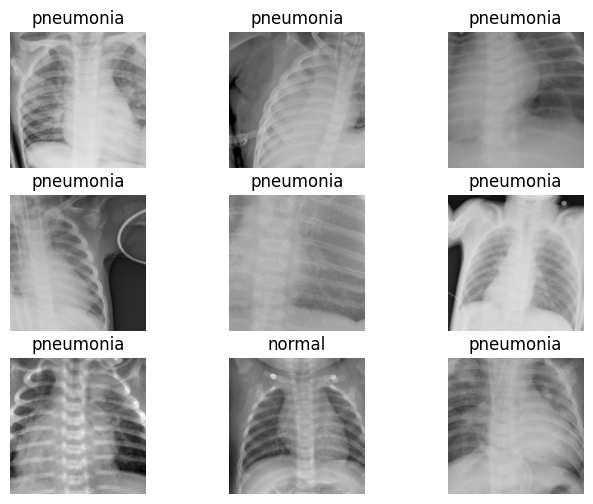

In [364]:
# Set up a new DataBlock for 2-class classification (Normal, Pneumonia)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path'),
    get_y=ColReader('image_class'),
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)] # Using ImageNet stats for consistency
)

# Create DataLoaders for the 2-class classification task
dls = dblock.dataloaders(df)

print("Image classification - pneumonia or normal")
dls.show_batch(figsize=(8, 6))


Pneumonia image sub classification


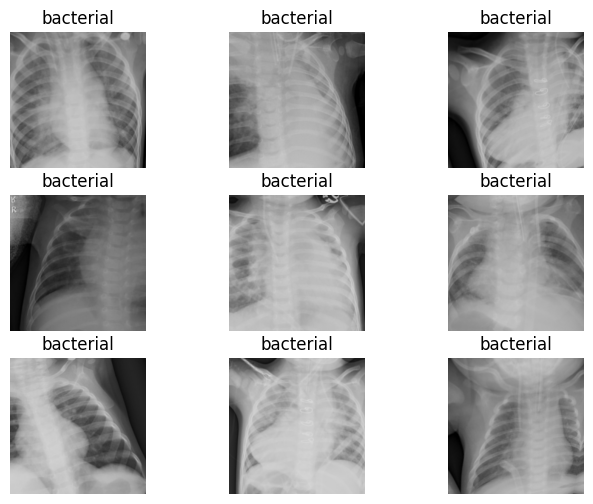

In [365]:
# Create a DataFrame for pneumonia images
df_pneumonia = df[df['image_class'] == 'pneumonia']

# Set up a new DataBlock for 2-sub classification (Bacterial, Viral)
dblock_sub = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path'),
    get_y=ColReader('image_subclass'),
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)] # Normalize
)

# Create DataLoaders for the 3-class classification task
dls_sub = dblock_sub.dataloaders(df_pneumonia)

print("Pneumonia image sub classification")

dls_sub.show_batch(figsize=(8, 6))

### Calculate image statistics


In [366]:
from pathlib import Path
import seaborn as sns
import random
from collections import Counter
import os

image_classes = df['image_class'].unique()
image_subclasses = df['image_subclass'].dropna().unique()
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
metrics_file = os.path.join(DATA_PATH, 'xray_images_metrics.csv')

# Check if metrics file exists
if os.path.exists(metrics_file):
    print(f"Loading metrics from {metrics_file}")
    df_metrics = pd.read_csv(metrics_file)
else:
    from joblib import Parallel, delayed
    import multiprocessing

    def compute_metrics(img_path):
        # Inline imports for parallel compatibility
        from PIL import Image
        from skimage import io, measure
        import numpy as np
        try:
            img = io.imread(str(img_path), as_gray=True).astype(np.float32)
            entropy = measure.shannon_entropy(img)
            contrast = img.std()
            mean = img.mean()
            signal_noise_ratio = mean / (contrast + 1e-8)
            pil_img = Image.open(img_path)
            width, height = pil_img.size
            return {
                'orig_file_path': str(img_path),
                'mean': mean,
                'contrast': contrast,
                'entropy': entropy,
                'signal_noise_ratio': signal_noise_ratio,
                'width': width,
                'height': height
            }
        except Exception:
            return {
                'orig_file_path': str(img_path),
                'mean': None,
                'contrast': None,
                'entropy': None,
                'signal_noise_ratio': None,
                'width': None,
                'height': None
            }
    # Use all available CPUs
    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs",num_cores)
    print("\n\n Compute Image Statistics...")
    results = Parallel(n_jobs=num_cores)(
        delayed(compute_metrics)(f) for f in df['orig_file_path']
    )

    df_metrics = pd.DataFrame(results)

    # Save the DataFrame with metrics
    df_metrics.to_csv(metrics_file, index=False)
    print(f"Metrics computed and saved to {metrics_file}")

df = df.merge(df_metrics, on='orig_file_path', how='left')

df.info()

Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5614 entries, 0 to 5613
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   orig_file_path      5614 non-null   object 
 1   file_name           5614 non-null   object 
 2   image_class         5614 non-null   object 
 3   image_subclass      4031 non-null   object 
 4   usage_type          5614 non-null   object 
 5   mean                5614 non-null   float64
 6   contrast            5614 non-null   float64
 7   entropy             5614 non-null   float64
 8   signal_noise_ratio  5614 non-null   float64
 9   width               5614 non-null   int64  
 10  height              5614 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 482.6+ KB


### Plot image statistics

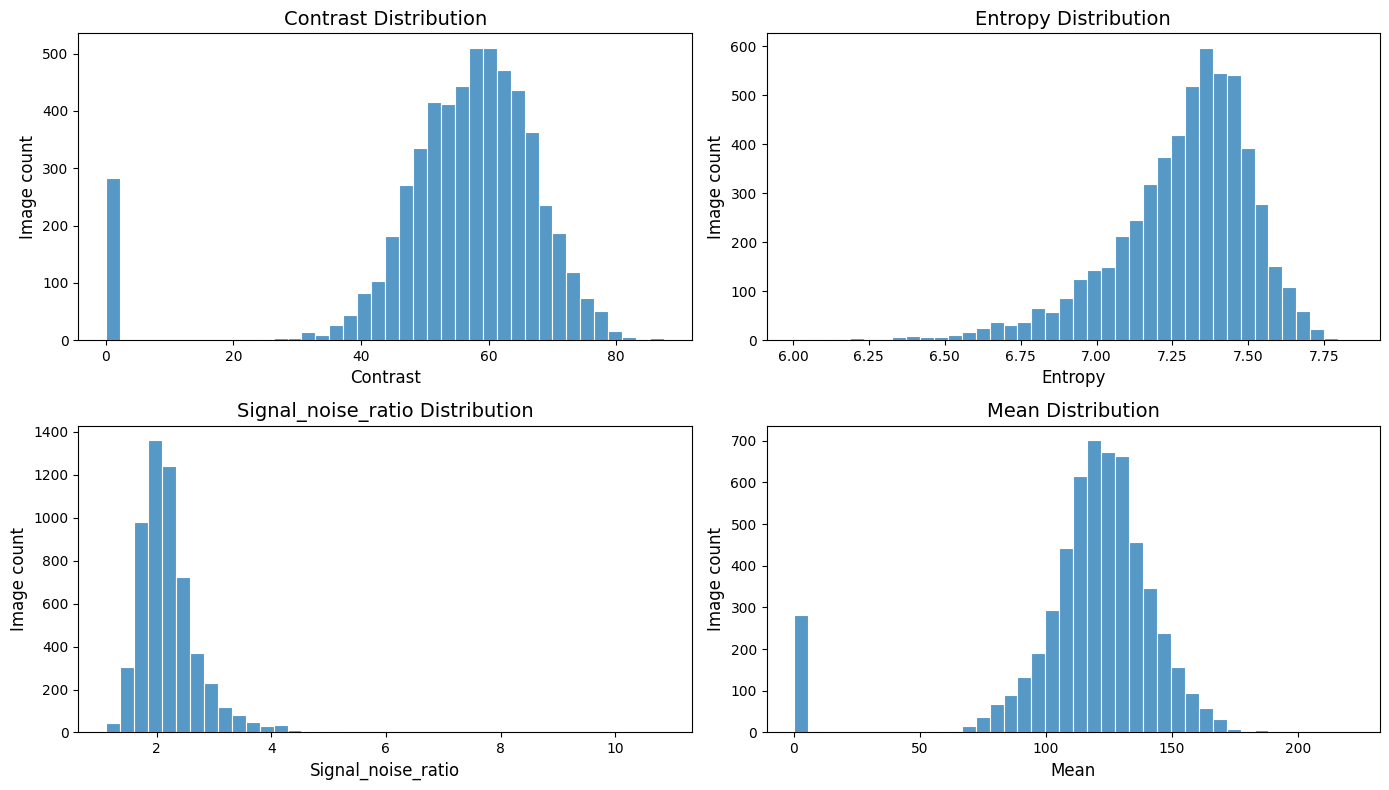

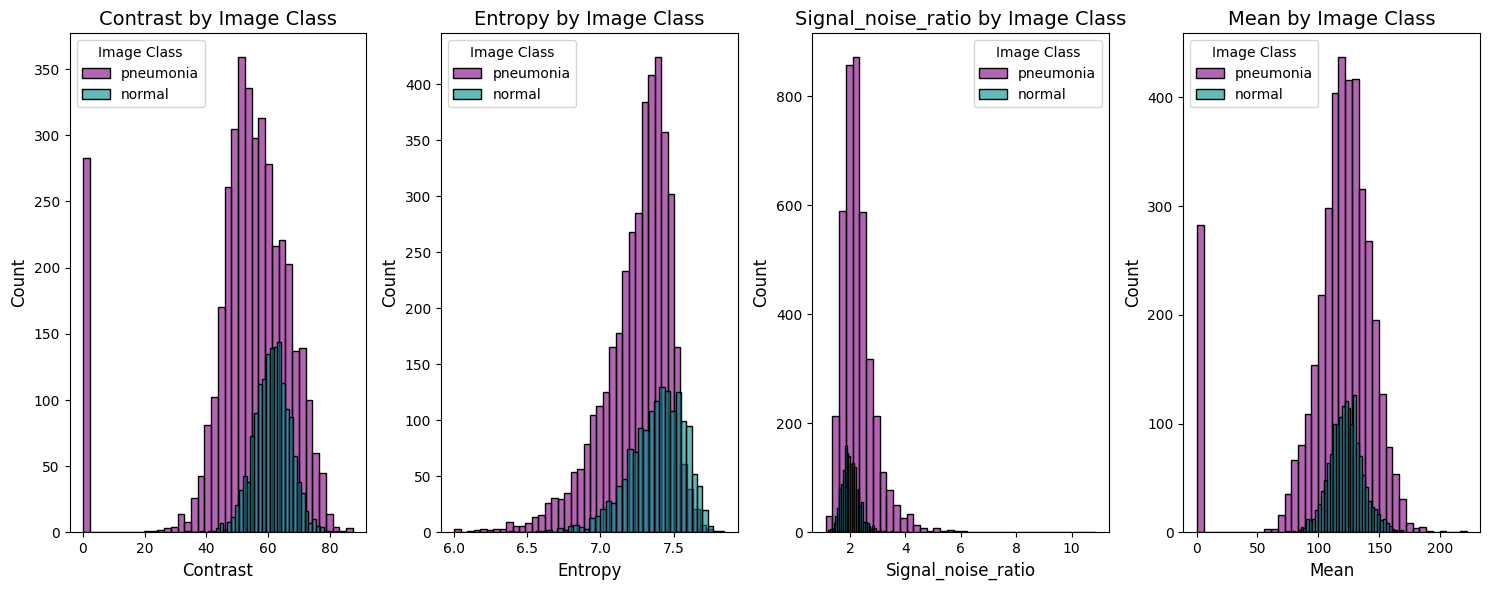

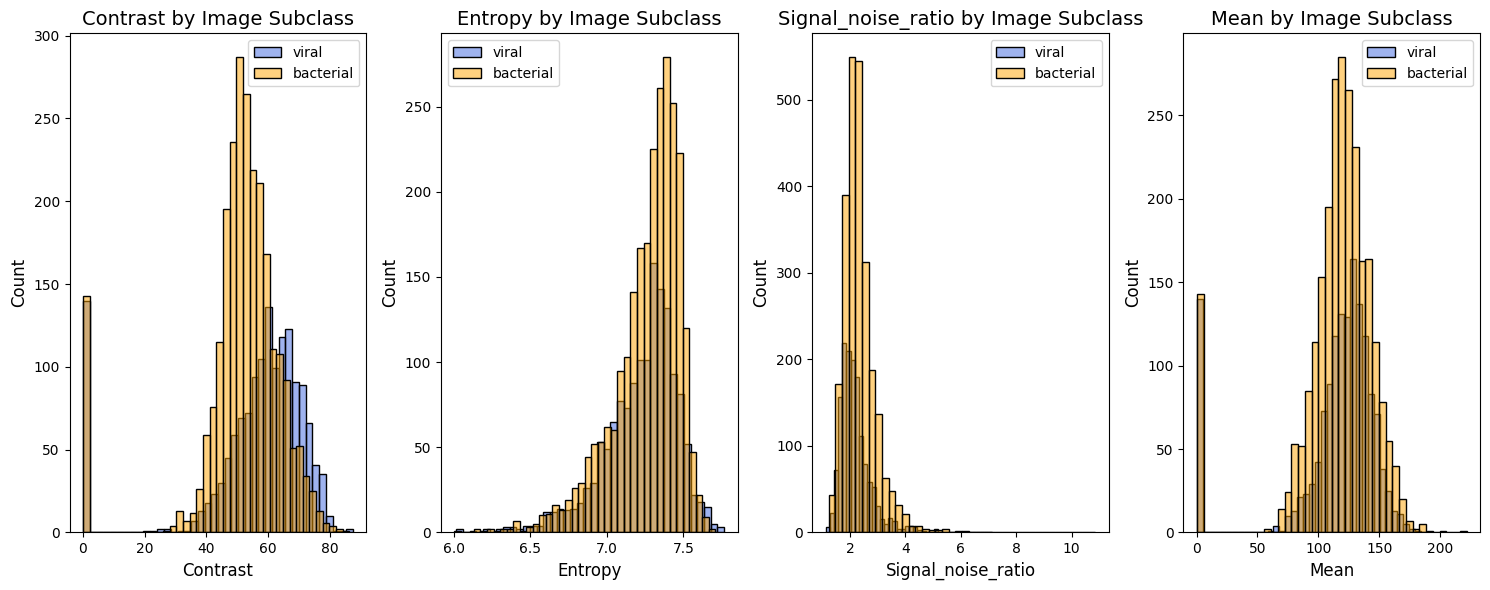

In [367]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df[df['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df[df['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()






### Identify and remove low quality images

**Indentify low contrast images**

Low contrast images

             mean    contrast     entropy  signal_noise_ratio        width  \
count  283.000000  283.000000  283.000000          283.000000   283.000000   
mean     0.521522    0.169181    7.032713            3.231380   735.519435   
std      0.070698    0.034087    0.258813            0.919251   187.939335   
min      0.276649    0.082195    6.196695            1.708955   384.000000   
25%      0.477175    0.142575    6.882421            2.554215   553.500000   
50%      0.529134    0.168610    7.043355            3.029931   759.000000   
75%      0.565335    0.192179    7.217175            3.732631   863.500000   
max      0.722116    0.265026    7.638877            7.364879  1287.000000   

           height  
count  283.000000  
mean   434.247350  
std    158.876515  
min    127.000000  
25%    284.000000  
50%    467.000000  
75%    553.500000  
max    720.000000   



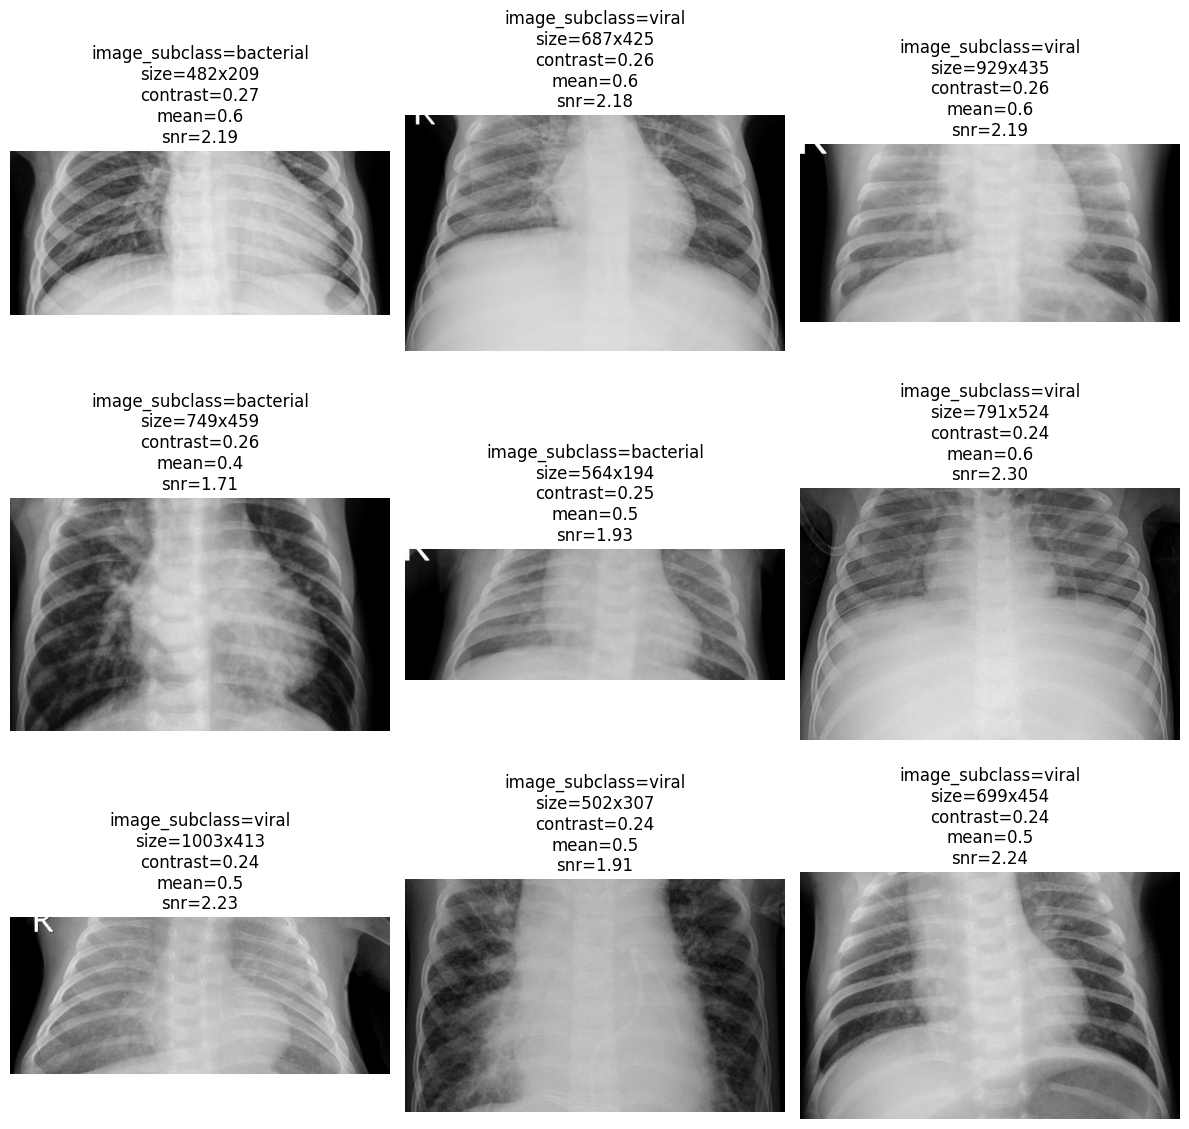

In [368]:
# Find images where contrast is below 10 (low quality images)
threshold = 10
num_to_show = 9
low_contrast = df[df['contrast'] < threshold].sort_values(by='contrast', ascending=False)

print("Low contrast images\n")
print(low_contrast.describe(),"\n")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, (idx, row) in enumerate(low_contrast.head(num_to_show).iterrows()):
    img_path = row['orig_file_path']
    img = Image.open(img_path)
    width, height = img.size
    ax = axs[i//3, i%3]
    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"image_subclass={row['image_subclass']}\n"
        f"size={width}x{height}\n"
        f"contrast={row['contrast']:.2f}\n"
        f"mean={row['mean']:.1f}\n"
        f"snr={row['signal_noise_ratio']:.2f}"
    )
    ax.axis('off')


plt.tight_layout()
plt.show()

**Identify small images**

---



In [369]:
## Identify smaller images than ImageNet(244)
size_threshold = 244
small_img = df[(df['width'] < size_threshold) | (df['height'] < size_threshold)]
small_img.describe()


,mean,contrast,entropy,signal_noise_ratio,width,height
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.520223,0.180217,6.981163,2.999986,470.711538,191.865385
std,0.061729,0.033911,0.276100,0.780958,39.086298,30.943990
min,0.278992,0.109440,6.343618,1.930794,384.000000,127.000000
25%,0.479786,0.158178,6.835328,2.522469,445.000000,172.750000
50%,0.527518,0.176687,7.013103,2.882158,464.500000,189.500000
75%,0.560636,0.204300,7.180647,3.171103,492.500000,218.250000
max,0.675744,0.265026,7.449246,5.536824,564.000000,242.000000


**Remove low quality images**

In [370]:
# Get filenames to remove
remove_filenames = pd.concat([low_contrast['orig_file_path'], small_img['orig_file_path']]).unique()


print("Number of images to remove",len(remove_filenames))
df_clean = df[~df['orig_file_path'].isin(remove_filenames)]
df_clean =  df_clean.reset_index(drop=True)

df_clean.to_csv(os.path.join(DATA_PATH, 'df_clean.csv'),index=False)

df_clean.info()

df_clean.groupby(['usage_type', 'image_class', 'image_subclass'], dropna=False)['orig_file_path'].count()

Number of images to remove 283
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   orig_file_path      5331 non-null   object 
 1   file_name           5331 non-null   object 
 2   image_class         5331 non-null   object 
 3   image_subclass      3748 non-null   object 
 4   usage_type          5331 non-null   object 
 5   mean                5331 non-null   float64
 6   contrast            5331 non-null   float64
 7   entropy             5331 non-null   float64
 8   signal_noise_ratio  5331 non-null   float64
 9   width               5331 non-null   int64  
 10  height              5331 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 458.3+ KB


usage_type  image_class  image_subclass
test        normal       NaN                234
            pneumonia    viral              148
train       normal       NaN               1341
            pneumonia    bacterial         2387
                         viral             1205
validation  normal       NaN                  8
            pneumonia    bacterial            8
Name: orig_file_path, dtype: int64

### Convert images to RGB

In [371]:
from joblib import Parallel, delayed

processed_output_dir = DATA_PATH + '/chest_xray_processed/rgb'
if os.path.exists(processed_output_dir):
    print(f"RGB folder '{processed_output_dir}' exists. Skipping conversion step.")
else:
    os.makedirs(processed_output_dir, exist_ok=True)

    def convert_to_rgb_save_row(row, base_dir=processed_output_dir):
        src_path = row['orig_file_path']
        dest_path = get_img_processed_dest_path(row, base_dir) # Correctly passing base_dir
        try:
            img = Image.open(src_path)
            was_converted = False
            if img.mode != 'RGB':
                img = img.convert('RGB')
                was_converted = True
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            img.save(dest_path)
            return was_converted
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
            return False

    num_cores = multiprocessing.cpu_count()
    print("Convert images to RGB...")
    results = Parallel(n_jobs=num_cores)(
        delayed(convert_to_rgb_save_row)(row, processed_output_dir) # Ensure base_dir is passed here too
        for _, row in df_clean.iterrows()
    )

    nonRGBCount = sum(results)
    print("RGB conversion count:", nonRGBCount)


RGB folder '/content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/chest_xray_processed/rgb' exists. Skipping conversion step.


## Prepare Training Data
In this section we will create 2  datasets to use for training.

In [372]:
def get_img_processed_dest_path(row, base_dir):
    parts = [
        base_dir,
        str(row['usage_type']),
        str(row['image_class']),
        str(row['file_name'])
    ]
    return os.path.join(*parts)

## Get cleaned images data
df_clean = pd.read_csv(os.path.join(DATA_PATH, 'df_clean.csv'))

## Set with basic filtering and transformation
processed_images_standard_path = DATA_PATH+'/chest_xray_processed/rgb'

## Set with additional image transformation
processed_images_augm_path = DATA_PATH+'/chest_xray_processed/augm'

df_clean['proc_rgb_file_path'] = df_clean.apply(
    get_img_processed_dest_path,
    axis=1, #apply per row
    base_dir = processed_images_standard_path # Corrected to use standard RGB path
)

df_clean['proc_augm_file_path'] = df_clean.apply(
    get_img_processed_dest_path,
    axis=1, #apply per row
    base_dir = processed_images_augm_path # Corrected to use augmented path
)



### Training images set 1

For training set 1 we will we use processed images with only RGB conversion.

In [373]:
df_training_set1 = df_clean.copy()
df_training_set1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   orig_file_path       5331 non-null   object 
 1   file_name            5331 non-null   object 
 2   image_class          5331 non-null   object 
 3   image_subclass       3748 non-null   object 
 4   usage_type           5331 non-null   object 
 5   mean                 5331 non-null   float64
 6   contrast             5331 non-null   float64
 7   entropy              5331 non-null   float64
 8   signal_noise_ratio   5331 non-null   float64
 9   width                5331 non-null   int64  
 10  height               5331 non-null   int64  
 11  proc_rgb_file_path   5331 non-null   object 
 12  proc_augm_file_path  5331 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 541.6+ KB


### Compute and plot statistics

In [374]:
from pathlib import Path
import seaborn as sns
import random
from collections import Counter
import os

image_classes = df_training_set1['image_class'].unique()
image_subclasses = df_training_set1['image_subclass'].dropna().unique()
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
metrics_file = os.path.join(DATA_PATH, 'xray_images_metrics_set1.csv')

# Check if metrics file exists
if os.path.exists(metrics_file):
    print(f"Loading metrics from {metrics_file}")
    df_metrics_set1 = pd.read_csv(metrics_file)
else:
    from joblib import Parallel, delayed
    import multiprocessing

    def recompute_metrics(img_path, row):
      from PIL import Image
      from skimage import io, measure
      import numpy as np
      try:
          img = io.imread(str(img_path)).astype(np.float32)
          entropy = measure.shannon_entropy(img)
          contrast = img.std()
          mean = img.mean()
          signal_noise_ratio = mean / (contrast + 1e-8)
          return {
              'orig_file_path': row['orig_file_path'],
              'mean': mean,
              'contrast': contrast,
              'entropy': entropy,
              'signal_noise_ratio': signal_noise_ratio
          }
      except Exception:
          return {
              'orig_file_path': row['orig_file_path'],
              'mean': None,
              'contrast': None,
              'entropy': None,
              'signal_noise_ratio': None
          }


    #clean statistics
    df_training_set1 = df_training_set1.drop(
      columns=['mean', 'contrast', 'entropy', 'signal_noise_ratio'],
      errors='ignore'
    )

    # Use all available CPUs
    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs",num_cores)
    print("\n\n Compute Image Statistics...")

    results = Parallel(n_jobs=num_cores)(
      delayed(recompute_metrics)(row['proc_rgb_file_path'], row)
      for _, row in df_training_set1.iterrows()
    )

    df_metrics_set1 = pd.DataFrame(results)

    # Save the DataFrame with metrics
    df_metrics_set1.to_csv(metrics_file, index=False)
    print(f"Metrics computed and saved to {metrics_file}")

    df_training_set1 = df_training_set1.merge(
      df_metrics_set1,
      on='orig_file_path',
      how='left')

df_training_set1.describe()

Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics_set1.csv


,mean,contrast,entropy,signal_noise_ratio,width,height
count,5331.000000,5331.000000,5331.000000,5331.000000,5331.000000,5331.000000
mean,122.531145,57.922986,7.297830,2.162732,1370.758394,1010.353780
std,18.281393,8.886110,0.219931,0.488755,344.527068,373.437298
min,58.722980,20.415352,6.004755,1.123288,664.000000,360.000000
25%,111.421697,51.695595,7.190910,1.853357,1096.000000,728.000000
50%,122.506070,58.178740,7.336715,2.093565,1320.000000,933.000000
75%,133.756080,64.150860,7.444886,2.370289,1592.000000,1224.000000
max,221.536650,87.480420,7.841582,10.851474,2916.000000,2713.000000


Training Set 1


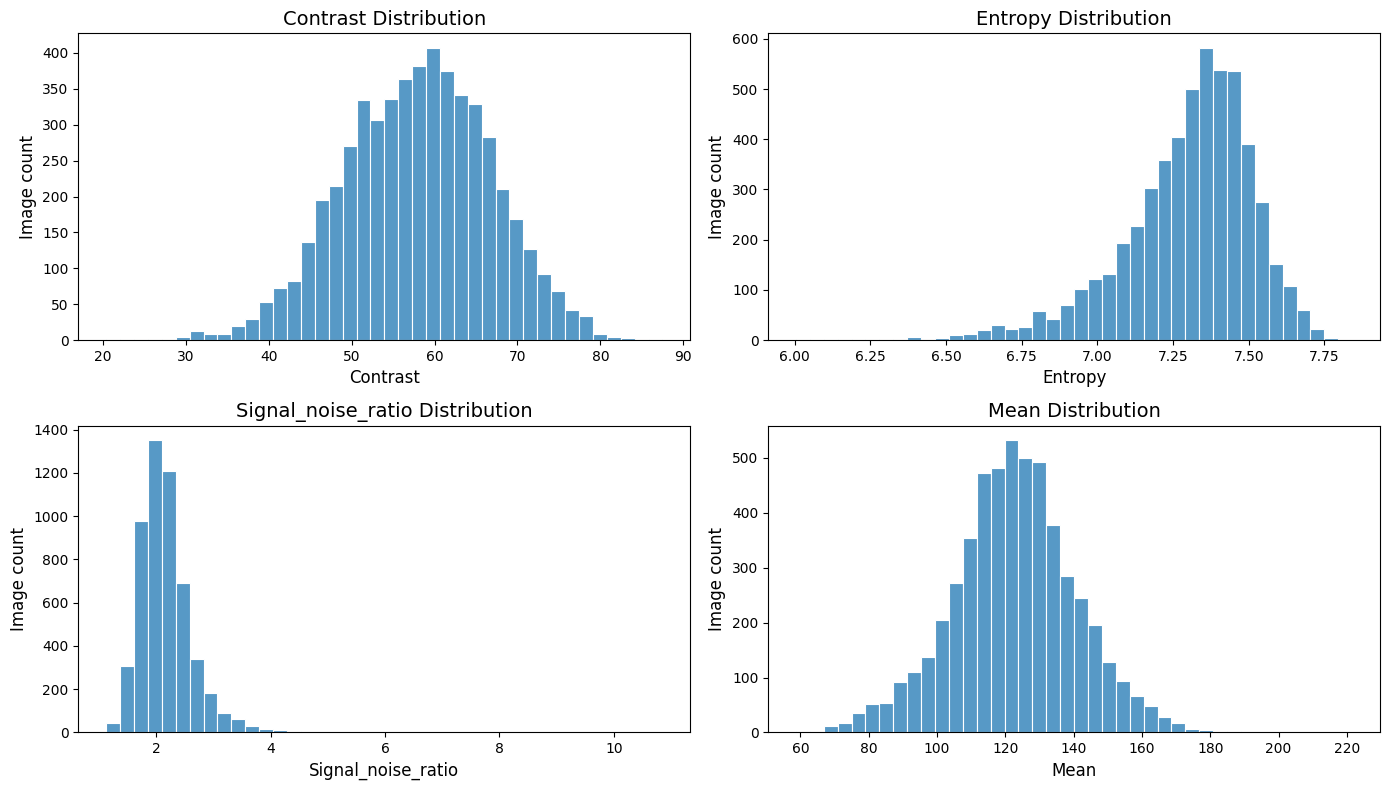

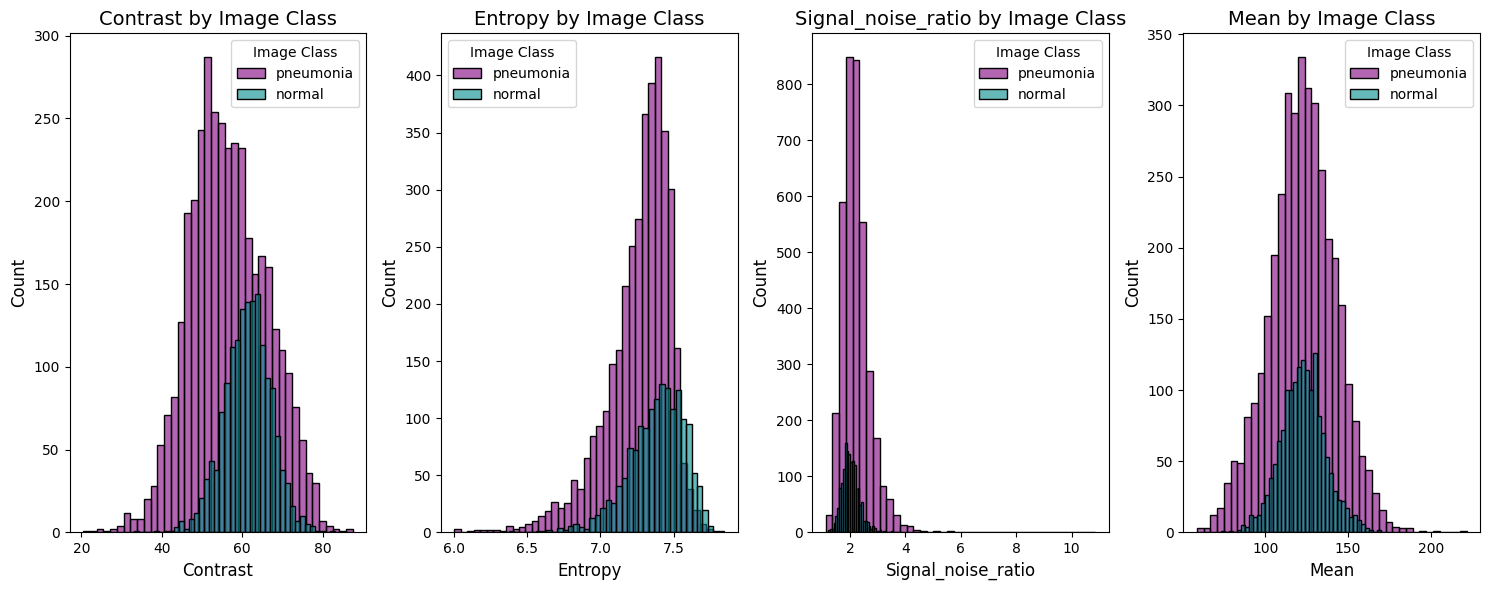

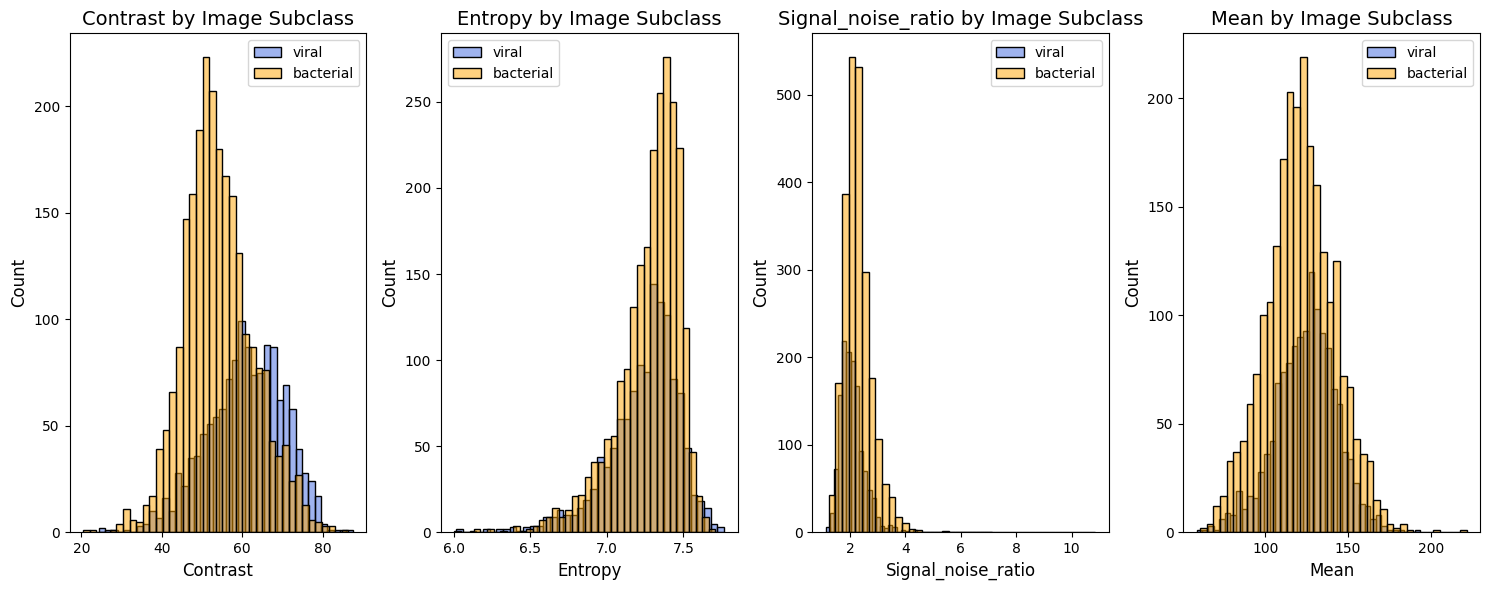

In [375]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt


print("Training Set 1")
plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df_training_set1[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df_training_set1[df_training_set1['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df_training_set1[df_training_set1['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()



### Training images set 2

In [376]:
flagged = []
cutoffs = {}
# Flag low quality images in each classification
for cls in image_classes:
    subdf = df_training_set2[df_training_set2['image_class'] == cls]
    n = len(subdf)
    #cut bottom 10% of outliers for contrast, entropy, and signal noise ratio

    cutoffs[cls] = {
        'contrast': subdf['contrast'].quantile(0.10),
        'entropy':  subdf['entropy'].quantile(0.10),
        'signal_noise_ratio':      subdf['signal_noise_ratio'].quantile(0.10)
    }

    low_q_images = subdf[
        (subdf['contrast'] < cutoffs[cls]['contrast']) |
        (subdf['entropy']  < cutoffs[cls]['entropy'])  |
        (subdf['signal_noise_ratio']      < cutoffs[cls]['signal_noise_ratio'])
    ]['orig_file_path'].tolist()
    low_q_images = subdf[
        (subdf['contrast'] < cutoffs[cls]['contrast'])]['orig_file_path'].tolist()
    flagged += low_q_images
    print("\nImage Class",cls)
    print("\nMetrics Thresholds (Lower)",cutoffs[cls])
    print("\nTotal training imaages",n,"Flagged for low quality:",len(low_q_images),"Remaing",n-len(low_q_images))

#remove flagged images from training set 2
df_training_set2 = df_training_set2[~df_training_set2['orig_file_path'].isin(flagged)]

df_training_set2.groupby('image_class').count()


Image Class normal

Metrics Thresholds (Lower) {'contrast': np.float64(53.970400600000005), 'entropy': np.float64(7.133692574122984), 'signal_noise_ratio': np.float64(1.656965)}

Total training imaages 1583 Flagged for low quality: 159 Remaing 1424

Image Class pneumonia

Metrics Thresholds (Lower) {'contrast': np.float64(45.009533), 'entropy': np.float64(6.967635130531499), 'signal_noise_ratio': np.float64(1.6760778600000001)}

Total training imaages 3748 Flagged for low quality: 375 Remaing 3373


,orig_file_path,file_name,image_subclass,usage_type,mean,contrast,entropy,signal_noise_ratio,width,height,proc_rgb_file_path,proc_augm_file_path
image_class,,,,,,,,,,,,
normal,1424,1424,0,1424,1424,1424,1424,1424,1424,1424,1424,1424
pneumonia,3373,3373,3373,3373,3373,3373,3373,3373,3373,3373,3373,3373


In this set we will use our image statistics and remove low quality images by removing  outliers.

In [377]:
df_training_set2 = df_clean.copy()
df_training_set2.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   orig_file_path       5331 non-null   object 
 1   file_name            5331 non-null   object 
 2   image_class          5331 non-null   object 
 3   image_subclass       3748 non-null   object 
 4   usage_type           5331 non-null   object 
 5   mean                 5331 non-null   float64
 6   contrast             5331 non-null   float64
 7   entropy              5331 non-null   float64
 8   signal_noise_ratio   5331 non-null   float64
 9   width                5331 non-null   int64  
 10  height               5331 non-null   int64  
 11  proc_rgb_file_path   5331 non-null   object 
 12  proc_augm_file_path  5331 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 541.6+ KB


Apply CLAHE image adjustments and save as RGB

In [378]:
import os
import numpy as np
from skimage import io, exposure, img_as_ubyte
from joblib import Parallel, delayed
import multiprocessing

processed_output_dir = DATA_PATH + '/chest_xray_processed/augm'

# Skip all processing if processed output folder exists
if os.path.exists(processed_output_dir):
    print(f"CLAHE: Folder '{processed_output_dir}' already exists. Skipping CLAHE batch.")
else:
    os.makedirs(processed_output_dir, exist_ok=True)

    def apply_clahe_and_save(row):
        try:
            img = io.imread(row['orig_file_path'])

            # Convert to grayscale if RGB
            if img.ndim == 3:
                from skimage.color import rgb2gray
                img_gray = rgb2gray(img)
            else:
                img_gray = img / 255.0 if img.max() > 1 else img

            # Apply CLAHE
            img_clahe = exposure.equalize_adapthist(img_gray, clip_limit=0.03)
            img_clahe_uint8 = img_as_ubyte(img_clahe)  # [0,1] float -> uint8

            # Convert to RGB by stacking channels
            img_rgb = np.stack([img_clahe_uint8] * 3, axis=-1)

            # Ensure output directory for this file exists
            os.makedirs(os.path.dirname(row['proc_augm_file_path']), exist_ok=True)
            # Save to file (PNG, JPEG, etc.)
            io.imsave(row['proc_augm_file_path'], img_rgb)
            return True
        except Exception as e:
            print(f"Failed on {row['orig_file_path']}: {e}")
            return False

    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs", num_cores)
    print("\n\n Compute Image Statistics...")

    results = Parallel(n_jobs=num_cores)(
        delayed(apply_clahe_and_save)(row)
        for _, row in df_training_set2.iterrows()
    )
df_training_set2.info()

CLAHE: Folder '/content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/chest_xray_processed/augm' already exists. Skipping CLAHE batch.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   orig_file_path       5331 non-null   object 
 1   file_name            5331 non-null   object 
 2   image_class          5331 non-null   object 
 3   image_subclass       3748 non-null   object 
 4   usage_type           5331 non-null   object 
 5   mean                 5331 non-null   float64
 6   contrast             5331 non-null   float64
 7   entropy              5331 non-null   float64
 8   signal_noise_ratio   5331 non-null   float64
 9   width                5331 non-null   int64  
 10  height               5331 non-null   int64  
 11  proc_rgb_file_path   5331 non-null   object 
 12  proc_augm_file_path  5331 

### Compute and plot statistics

In [379]:
from pathlib import Path
import seaborn as sns
import random
from collections import Counter
import os

image_classes = df_training_set2['image_class'].unique()
image_subclasses = df_training_set2['image_subclass'].dropna().unique()
metrics = ['contrast', 'entropy', 'signal_noise_ratio', 'mean']
metrics_file = os.path.join(DATA_PATH, 'xray_images_metrics_set2.csv')

# Check if metrics file exists
if os.path.exists(metrics_file):
    print(f"Loading metrics from {metrics_file}")
    df_metrics_set2 = pd.read_csv(metrics_file)
else:
    from joblib import Parallel, delayed
    import multiprocessing

    def recompute_metrics(img_path, row):
      from PIL import Image
      from skimage import io, measure
      import numpy as np
      try:
          img = io.imread(str(img_path)).astype(np.float32)
          entropy = measure.shannon_entropy(img)
          contrast = img.std()
          mean = img.mean()
          signal_noise_ratio = mean / (contrast + 1e-8)
          return {
              'orig_file_path': row['orig_file_path'],
              'mean': mean,
              'contrast': contrast,
              'entropy': entropy,
              'signal_noise_ratio': signal_noise_ratio
          }
      except Exception:
          return {
              'orig_file_path': row['orig_file_path'],
              'mean': None,
              'contrast': None,
              'entropy': None,
              'signal_noise_ratio': None
          }


    #clean statistics
    df_training_set2 = df_training_set2.drop(
      columns=['mean', 'contrast', 'entropy', 'signal_noise_ratio'],
      errors='ignore'
    )

    # Use all available CPUs
    num_cores = multiprocessing.cpu_count()
    print("\nNumber of available CPUs",num_cores)
    print("\n\n Compute Image Statistics...")

    results = Parallel(n_jobs=num_cores)(
      delayed(recompute_metrics)(row['proc_augm_file_path'], row)
      for _, row in df_training_set2.iterrows()
    )

    df_metrics_set2 = pd.DataFrame(results)

    # Save the DataFrame with metrics
    df_metrics_set2.to_csv(metrics_file, index=False)
    print(f"Metrics computed and saved to {metrics_file}")

    df_training_set2 = df_training_set2.merge(
      df_metrics_set2,
      on='orig_file_path',
      how='left')

df_training_set2.info()

Loading metrics from /content/drive/MyDrive/SeattleU/5100-DataIntro/Projects/image-classification/data/xray_images_metrics_set2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   orig_file_path       5331 non-null   object 
 1   file_name            5331 non-null   object 
 2   image_class          5331 non-null   object 
 3   image_subclass       3748 non-null   object 
 4   usage_type           5331 non-null   object 
 5   mean                 5331 non-null   float64
 6   contrast             5331 non-null   float64
 7   entropy              5331 non-null   float64
 8   signal_noise_ratio   5331 non-null   float64
 9   width                5331 non-null   int64  
 10  height               5331 non-null   int64  
 11  proc_rgb_file_path   5331 non-null   object 
 12  proc_augm_file_path  5331 non-null   object 
dtypes: flo

Training Set 2


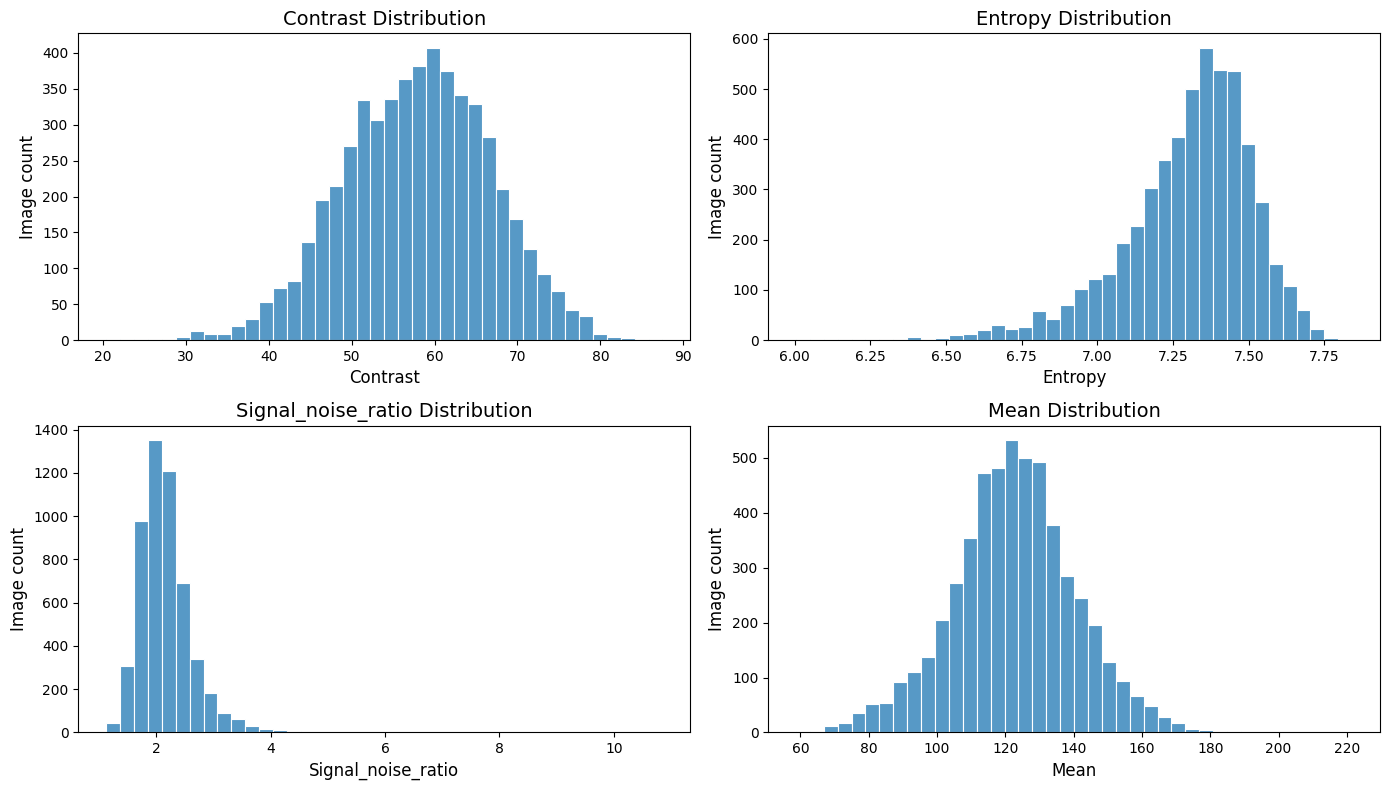

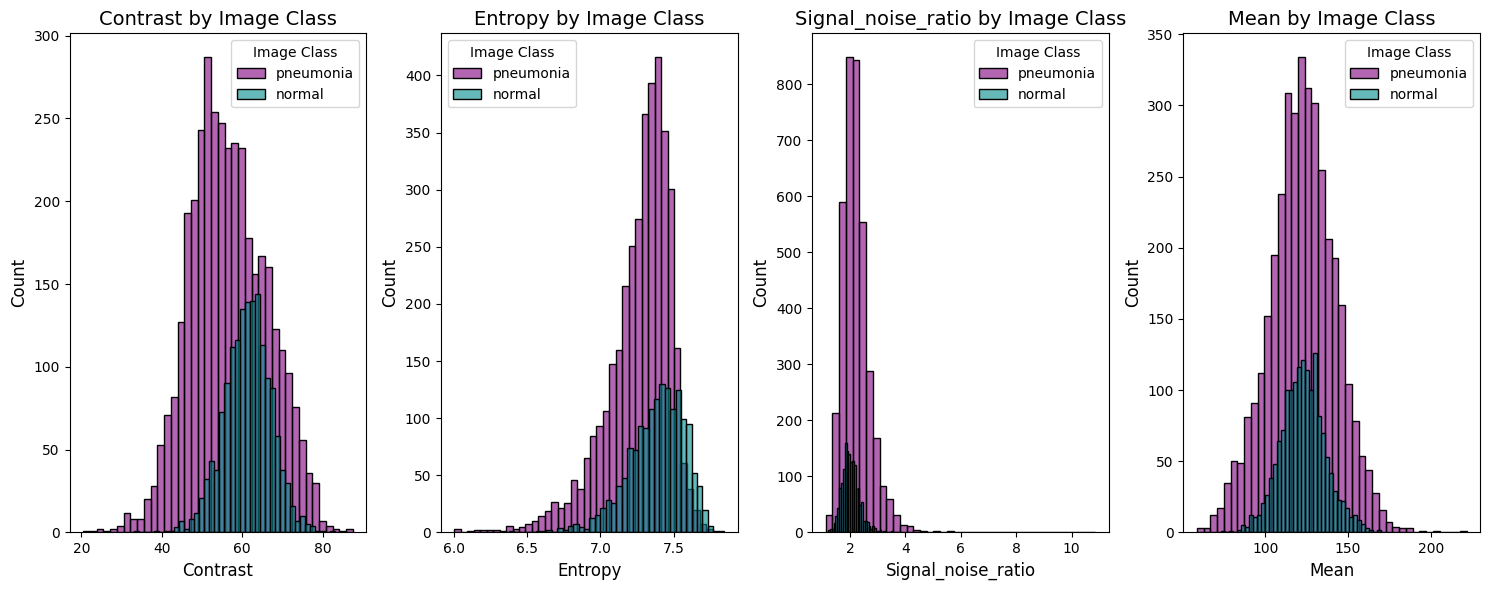

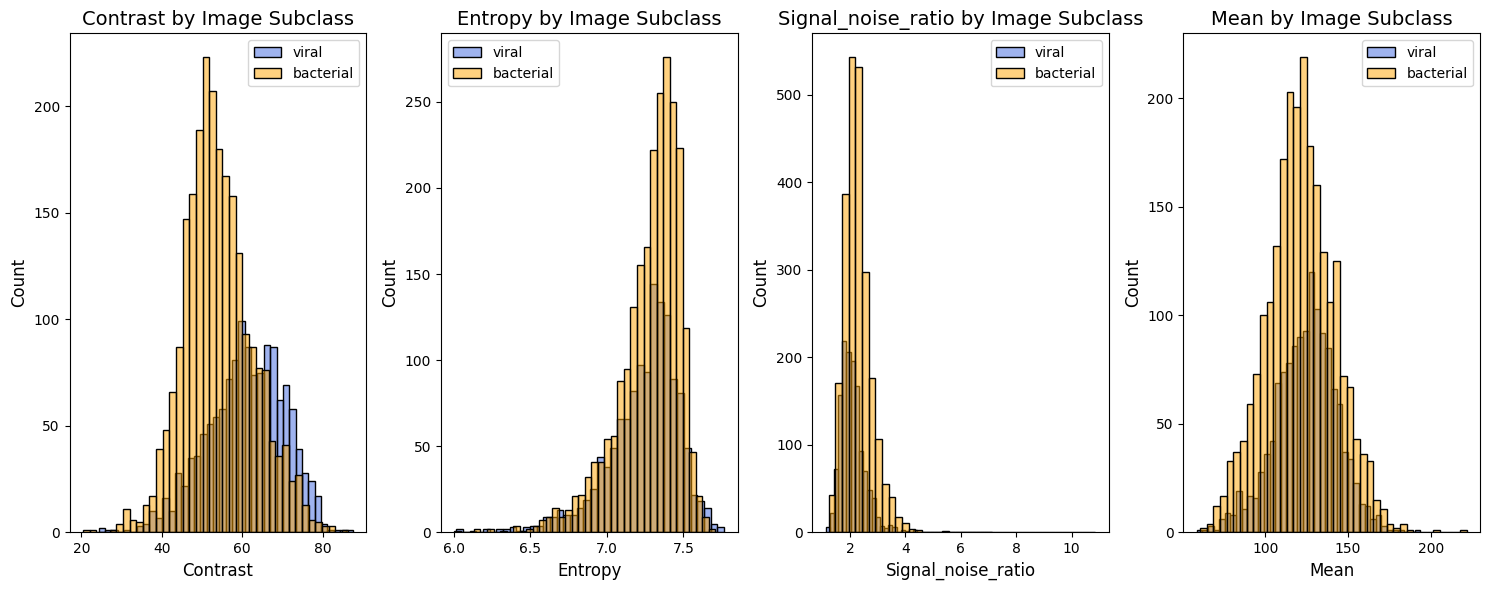

In [380]:
#Plot diagrams for each metric
import seaborn as sns
import matplotlib.pyplot as plt


print("Training Set 2")
plt.figure(figsize=(14, 8))
for i in range(len(metrics)):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        df_training_set2[metrics[i]].dropna(),
        bins=40,
        edgecolor='white'
    )
    plt.title(f'{metrics[i].capitalize()} Distribution', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Image count', fontsize=12)
plt.tight_layout()
plt.show()


# Plot diagrams for each image-class
class_color_map = {
    'pneumonia': 'purple', # bold red
    'normal': 'darkcyan',    # teal/green
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in ['pneumonia', 'normal']:
        vals = df_training_set2[df_training_set2['image_class'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.6,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Class', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Image Class')
plt.tight_layout()
plt.show()

# Plot diagrams for each image-subclass
class_color_map = {
    'bacterial': 'orange',
    'viral': 'royalblue',
}

plt.figure(figsize=(15, 6))
for i in range(len(metrics)):
    plt.subplot(1, 4, i + 1)
    for cls in image_subclasses:
        vals = df_training_set2[df_training_set2['image_subclass'] == cls][metrics[i]].dropna()
        sns.histplot(
            vals,
            bins=40,
            label=cls,
            alpha=0.5,
            linewidth=1,
            color=class_color_map.get(cls, None)
        )
    plt.title(f'{metrics[i].capitalize()} by Image Subclass', fontsize=14)
    plt.xlabel(metrics[i].capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()



## Modeling

We will use a deep neural network to build the classification model. Rather than training a network from scratch, we will modify an existing deep neural network to solve the problem of recognizing types of pneumonia.

The model will be based on the ResNet-50 deep neural network that was trained on the [ImageNet](https://www.image-net.org/) dataset.

![picture](https://storage.googleapis.com/kaggle-datasets-images/6978/10038/d9e74a548a8cdca167b38520ac8bf405/data-original.png?t=2017-12-13-20-32-53)

The ImageNet data set consists of images of many types.

We will use transfer learning to train the network to classify images of chest x-rays as normal, pneumonia viral, and pneumonia bacterial.


### Training model and validation

We will train a model to classify images as normal, viral pneumonia, and bacterial pneumonia, starting from the resnet50 model that has already been trained to solve an image classification problem involing many types of images.

We create a `vision_learner` object by specifying:

(1) the data loader created above `dls`,

(2) the name of the neural network we want to use as the basis for the model `resnet50`, and

(3) the metric we want to use to evaluate the performance of the model `error_rate`.


We can then fine tune the weights of the model to perform our specific task by minimizing the error for a specified number of epochs.

#### Training Set 1

Stage 1

In [381]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

df_set1_train = df_training_set1[df_training_set1['usage_type']=='train']
df_set1_test = df_training_set1[df_training_set1['usage_type']=='test']
df_set1_val = df_training_set1[df_training_set1['usage_type']=='validation']

# DataBlock for normal vs pneumonia
dls_set1_stage1 = ImageDataLoaders.from_df(
    df_set1_train,
    valid_df=df_set1_val,
    path='/',
    fn_col='proc_rgb_file_path',
    label_col='image_class',
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    num_workers =8,
    bs=64
)

learn_set1_stage1 = vision_learner(
    dls_set1_stage1,
    resnet50,
    metrics=[error_rate, F1Score(average='macro'), Precision(), Recall()],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater),
        EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)

classes = np.array(['normal', 'pneumonia'])
labels = df_training_set1['image_class'].tolist()
class_weights = compute_class_weight('balanced', classes=classes, y=labels)

#print("Class weights (normal, pneumonia):", class_weights)

learn_set1_stage1.loss_func = CrossEntropyLossFlat(weight=torch.tensor(class_weights, dtype=torch.float).to(learn_set1_stage1.dls.device))


In [383]:
# STAGE 1 - Normal vs Pneumonia
learn_set1_stage1.lr_find(show_plot=False)
learn_set1_stage1.fit_one_cycle(4, 1e-3)      # Frozen head training
learn_set1_stage1.unfreeze()
learn_set1_stage1.fit_one_cycle(8, slice(1e-6, 1e-4))  # Custom discriminative LRs

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.546490,0.245976,0.086207,0.890985,0.942817,0.938889,00:25
1,0.406294,0.177109,0.057809,0.928999,0.979740,0.940278,00:25
2,0.293839,0.169990,0.051724,0.936877,0.988321,0.940278,00:25
3,0.240375,0.163986,0.044625,0.944529,0.981481,0.956944,00:25


Better model found at epoch 0 with f1_score value: 0.890985243140239.
Better model found at epoch 1 with f1_score value: 0.9289994201404549.
Better model found at epoch 2 with f1_score value: 0.9368769888342842.
Better model found at epoch 3 with f1_score value: 0.9445288326300985.


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.216522,0.158625,0.050710,0.937381,0.981322,0.948611,00:29
1,0.201677,0.152294,0.052738,0.935297,0.984058,0.943056,00:29
2,0.195592,0.148964,0.046653,0.942640,0.986994,0.948611,00:29
3,0.188779,0.135412,0.047667,0.940680,0.978663,0.955556,00:29
4,0.180399,0.120960,0.044625,0.944405,0.980114,0.958333,00:29
5,0.164535,0.118748,0.044625,0.944774,0.984241,0.954167,00:29
6,0.164401,0.119505,0.041582,0.948819,0.989899,0.952778,00:29
7,0.160306,0.116131,0.044625,0.944529,0.981481,0.956944,00:29


Better model found at epoch 0 with f1_score value: 0.9373806039913832.
Better model found at epoch 2 with f1_score value: 0.9426396195872117.
Better model found at epoch 4 with f1_score value: 0.9444045763962929.
Better model found at epoch 5 with f1_score value: 0.9447739990732867.
Better model found at epoch 6 with f1_score value: 0.9488192315921541.


#### Validating results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set1_stage1)
interp.plot_confusion_matrix(figsize=(6,6))


In [ ]:
learn_set1_stage1.recorder.plot_loss()

In [ ]:
interp.plot_top_losses(9)  # See your worst predictions
import matplotlib.pyplot as plt
plt.tight_layout(pad=2.0)

In [ ]:
learn_set1_stage1.load('model')  # Loads the best checkpoint (epoch 7)
# Save Stage 1 weights
learn_set1_stage1.save(DATA_PATH+'set1_stage1_pneumonia_detector')

Stage 2

In [ ]:
# Filter dataframes for pneumonia images only
df_set1_train_pneumonia = df_set1_train[df_set1_train['image_class']=='pneumonia']
df_set1_val_pneumonia = df_set1_val[df_set1_val['image_class']=='pneumonia']

# DataLoaders for subclassification (bacterial vs viral)
dls_set1_stage2 = ImageDataLoaders.from_df(
    df_set1_train_pneumonia,
    valid_df=df_set1_val_pneumonia,
    path='/',
    fn_col='proc_rgb_file_path',
    label_col='image_subclass',  # 'bacterial' or 'viral'
    item_tfms=Resize(224),
    num_workers=8,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    bs=64

)

learn_set1_stage2 = vision_learner(
    dls_set1_stage2,
    resnet50,
    metrics=[error_rate, F1Score(average='macro'), Precision(), Recall()],
    cbs=[
        SaveModelCallback(monitor='f1_score', comp=np.greater),
        EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)

classes = np.array(['bacterial', 'viral'])
labels = df_set1_train_pneumonia['image_subclass'].tolist()
class_weights = compute_class_weight('balanced', classes=classes, y=labels)

#print("Class weights (normal, pneumonia):", class_weights)

learn_set1_stage2.loss_func = CrossEntropyLossFlat(weight=torch.tensor(class_weights, dtype=torch.float).to(learn_set_stage2.dls.device))

In [ ]:
# Now train Stage 2 (it already "knows" what pneumonia looks like!)
learn_set1_stage2.lr_find(show_plot=False)
learn_set1_stage2.fit_one_cycle(6, lr_max=5e-4)  # Fine-tune the head
learn_set1_stage2.unfreeze()
learn_set1_stage2.fit_one_cycle(12, lr_max=slice(1e-7, 5e-5))  # Refine features



In [ ]:
learn_set1_stage2.fit_one_cycle(8, lr_max=slice(1e-7, 5e-5))

In [ ]:

learn_set1_stage2.recorder.plot_loss()

interp = ClassificationInterpretation.from_learner(learn_set1_stage2)
interp.plot_confusion_matrix()

interp.plot_top_losses(9)

Save results

In [ ]:
learn_set1_stage2.load('model')  # Loads the best checkpoint (epoch 7)
# Save Stage 1 weights
learn_set1_stage2.save(DATA_PATH+'set1_stage2_bacterial_viral_detector')

### Training Set 2 - After CALHE

In [ ]:
#Calculate stats based on Training Set 2
overall_mean_set2 = df_training_set2['mean'].mean()
per_image_var_set2 = df_training_set2['contrast'] ** 2  # Variance per image
var_means_set2 = df_training_set2['mean'].var()  # Variance of means across images
overall_var_set2 = per_image_var_set2.mean() + var_means_set2
overall_std_set2 = np.sqrt(overall_var_set2)

# Tensors for 3 channels (same value since grayscale)
custom_mean_set2 = torch.tensor([overall_mean_set2] * 3)
custom_std_set2 = torch.tensor([overall_std_set2] * 3)

#btch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
#btch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

btch_tfms=[*aug_transforms(do_flip=True,
            flip_vert=False,
            max_zoom=1.05,
            max_lighting=0.2,
            p_lighting=0.5 #probability of lighting augumentations
            ),
           Normalize.from_stats(mean=custom_mean_set2,std=custom_std_set2)]

dblock_set2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path'),
    get_y=ColReader('image_class'),
    splitter=RandomSplitter(seed=1),
    item_tfms=Resize(224),
    batch_tfms=btch_tfms
)

# Pass the DataFrame directly to dataloaders
dls_set2 = dblock_set2.dataloaders(df_training_set2)

learn_set2 =  vision_learner(dls_set1_aug, resnet50, metrics=[error_rate,F1Score(average='macro')]) #F1Score creates score per class which improves multi-classification training
learn_set2 = learn_set2.add_cb(MixUp(0.4))

In [ ]:
learn_set2.fine_tune(epochs= 30, cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))

In [ ]:
#Calculate stats based on Training Set 2 reduced to just pneumonia
df_training_set2_pneumonia = df_training_set2[df_training_set2['image_class'].str.startswith('pneumonia')]
df_training_set2_pneumonia.info()

overall_mean_set2_p = df_training_set2_pneumonia['mean'].mean()
per_image_var_set2_p = df_training_set2_pneumonia['contrast'] ** 2  # Variance per image
var_means_set2_p = df_training_set2_pneumonia['mean'].var()  # Variance of means across images
overall_var_set2_p = per_image_var_set2_p.mean() + var_means_set2_p
overall_std_set2_p = np.sqrt(overall_var_set2_p)

# Tensors for 3 channels (same value since grayscale)
custom_mean_set2_p = torch.tensor([overall_mean_set2_p] * 3)
custom_std_set2_p = torch.tensor([overall_std_set2_p] * 3)

#btch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
#btch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

btch_tfms=[*aug_transforms(do_flip=True,
            flip_vert=False,
            max_zoom=1.05,
            max_lighting=0.2,
            p_lighting=0.5 #probability of lighting augumentations
            ),
           Normalize.from_stats(mean=custom_mean_set2_p,std=custom_std_set2_p)]

dblock_set2_p = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path'),
    get_y=ColReader('image_class'),
    splitter=RandomSplitter(seed=1),
    item_tfms=Resize(224),
    batch_tfms=btch_tfms
)

# Pass the DataFrame directly to dataloaders
dls_set2_p = dblock_set2_p.dataloaders(df_training_set2_pneumonia)
learn_set2.dls=(dls_set2_p)
learn_set2.metrics=error_rate
#learn_set2 =  vision_learner(dls_set1_aug, resnet50, metrics=[error_rate,F1Score(average='macro')]) #F1Score creates score per class which improves multi-classification training
#learn_set2 = learn_set2.add_cb(MixUp(0.4))

In [ ]:
learn_set2.fine_tune(epochs= 30,base_lr=1e-4, cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))

Save results

In [ ]:
import pandas as pd

# For fastai Learner
df_recorder_set2 = learn_set2.recorder.values
df_training_set2_result = pd.DataFrame(df, columns=['train_loss', 'valid_loss', 'accuracy'])
df_training_set2_result.to_csv(os.path.join(MODEL_PATH, 'resnet50_training_set2_pneumonia_fine_tune_results.csv'), index=False)

##### Save training set 1 model

In [ ]:
learn_set2.export(os.path.join(MODEL_PATH, 'pneumonia_set2_resnet50_model.pkl'))

##### Assess model learning performance

Fast.ai has a `ClassificationInterpretation` function to help analyze the performance of the model.

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn_set2)

Plot the confusion matrix, which shows the number of images in the validation set that were correctly and incorrectly classified by the model.

In [ ]:
interp2.plot_confusion_matrix(figsize=(6,6))

### Test the model on the testing set

In [ ]:
# Create a DataBlock for the testing set
dblock_test = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('orig_file_path'),
    get_y=ColReader('image_class'),
    splitter=RandomSplitter(seed=1), # Using RandomSplitter here is fine as we're just creating DataLoaders for the whole test set
    item_tfms=Resize(224),
    batch_tfms=btch_tfms # Use the same batch transforms as training if applicable
)

# Create DataLoaders for the testing set
dls_test = dblock_test.dataloaders(df_test)

# Validate the trained model on the testing set
# The output will show the test loss and metrics (e.g., error_rate, F1Score)
test_results = learn_set2.validate(dl=dls_test.valid)

print("\nTest set results (loss, error_rate, F1Score):", test_results)

##### Show the top loss images

In [ ]:
interp2.plot_top_losses(5, figsize=(17, 8))

## Adjusting learning rate

We will look into adjusting learning rate to improve the results.

In [ ]:


#reset the model
learn = vision_learner(dls, resnet50, metrics=error_rate)

print("\nFine Tuning with Learning Rate Adjustments")

minER = 1
lastER = 0
epoch = 2

while lastER <= minER:

    # Current(Default) learning rate
    print("\nCurrent learning rate: ",learn.lr)

    # Find if there is better rate for current set of training data
    lrs = []

    for i in range(3):
        lr = learn.lr_find()
        lrs.append(lr)

    # Sort results by valley value
    results_sorted = sorted(lrs, key=lambda x: x.valley)
    recommendedLR = results_sorted[1]  # median

    print("Fine tunning with base learning rate: ", f"{recommendedLR.valley:.10f}")
    learn.fine_tune(epoch, base_lr=recommendedLR.valley)

    # Get error rate
    lastER = learn.recorder.values[-1][2] # Assuming error_rate is the 3rd metric
    minER = min(lastER, minER)

    print(f"Current Error Rate: {lastER:.6f}, Minimum Error Rate: {minER:.6f}")
    if lastER > minER:
      print("Error rate increased, stopping training.")

***Note: Rate Finder should be run few times to ensure consistency. I found consitent result around  was the most common.***

In [ ]:
learn.export(os.path.join(MODEL_PATH, 'pneumonia_resnet50_adjlr_model.pkl'))

### Assess model learning performance

fast.ai has a `ClassificationInterpretation` function to help analyze the performance of the model.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_set1)

Plot the confusion matrix, which shows the number of images in the validation set that were correctly and incorrectly classified by the model.

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

##### Show the top loss images

In [ ]:
interp.plot_top_losses(5, figsize=(8, 6))

## Deployment

We can use the model to predict the animal type for an example image.

In [ ]:
img = PILImage.create(file_names[500])

prediction,_,probs = learn.predict(img)

print(f"Predicted animal: {prediction}.")
print(f"Probability it is this animal is a dog =  {probs[1].item():.6f}")
img.to_thumb(192)

##### Try the the model with pictures of dogs or cats that you have of your own or find online.

Load a new dog or cat image to test the model. Try a picture of my dog:

In [ ]:
!wget -O Romi.png https://www.dropbox.com/scl/fi/nxxkxwzd19udfmkgq1vun/Romi_Workout.png?rlkey=m22qgnr1krt2p7u8ciick8mxl&dl=0

View the image

In [ ]:
img = PILImage.create('Romi.png')
img.to_thumb(300)

Predict the image class and plot the prediction

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

<pre>



















</pre>

##### Let's see what it predicts for a picture of [grumpy cat](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg/250px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg) from Wikipedia

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg/250px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg)



In [ ]:
# Download the image
!wget https://upload.wikimedia.org/wikipedia/commons/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg -O grumpy.jpg

# create the image
img = PILImage.create('grumpy.jpg')

# plot the image
img.to_thumb(192)

In [ ]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

Citation:
Waheed, S., Ghosh, S., & Gadekallu, T. R. (2022). Pre-processing methods in chest X-ray image classification. Frontiers in Medicine, 9, 898289. https://doi.org/10.3389/fmed.2022.898289